### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *
import sqlite3
from sqlite3 import Error

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [6]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location

In [7]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0
'''
# Creating database path
database_dir = '/home/database/'
database_file = 'lead_scoring_model_experimentation.db'
# function to create a connection to the sqlite database at database_dir
def create_sqlit_connection(db_path,db_file):
    """ 
    Description - create a database connection to a SQLite database 
    Input = database path , database file
    output = None
    """
    conn = None
    # creating a connection the sqlite db
    try:
        conn = sqlite3.connect(db_path+db_file)
        print(sqlite3.version) # print the version of sqlite
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()
            
# Creating connection to database
create_sqlit_connection(database_dir,database_file)

2.6.0


In [8]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [11]:
# setup pycaret 
Baseline_model_exp_01 = setup(data = dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_experiment=True,experiment_name='Baseline_model_exp_01',
                   log_plots=True, log_data=True,
                   verbose=True,log_profile=False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


### 4 : Model Experimentation with pycaret

In [12]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7386,0.8211,0.8317,0.7029,0.7619,0.4766,0.4849,0.6440
lightgbm,Light Gradient Boosting Machine,0.7385,0.8211,0.8343,0.7020,0.7624,0.4765,0.4854,4.2340
et,Extra Trees Classifier,0.7367,0.8176,0.8210,0.7044,0.7582,0.4729,0.4797,3.5620
dt,Decision Tree Classifier,0.7364,0.8166,0.8205,0.7041,0.7579,0.4723,0.4789,0.4680
rf,Random Forest Classifier,0.7346,0.8169,0.8394,0.6957,0.7608,0.4686,0.4791,1.3660
lr,Logistic Regression,0.7098,0.7837,0.8221,0.6731,0.7402,0.4189,0.4297,0.4580
ridge,Ridge Classifier,0.7005,0.0000,0.7962,0.6702,0.7278,0.4003,0.4077,0.2540
lda,Linear Discriminant Analysis,0.7005,0.7733,0.7961,0.6702,0.7277,0.4003,0.4077,0.9780
nb,Naive Bayes,0.6629,0.7335,0.8924,0.6134,0.7269,0.3241,0.3653,0.2200


In [13]:
# create a model which gives the highest accuracy
lgbm  = create_model('lightgbm', fold = 5)

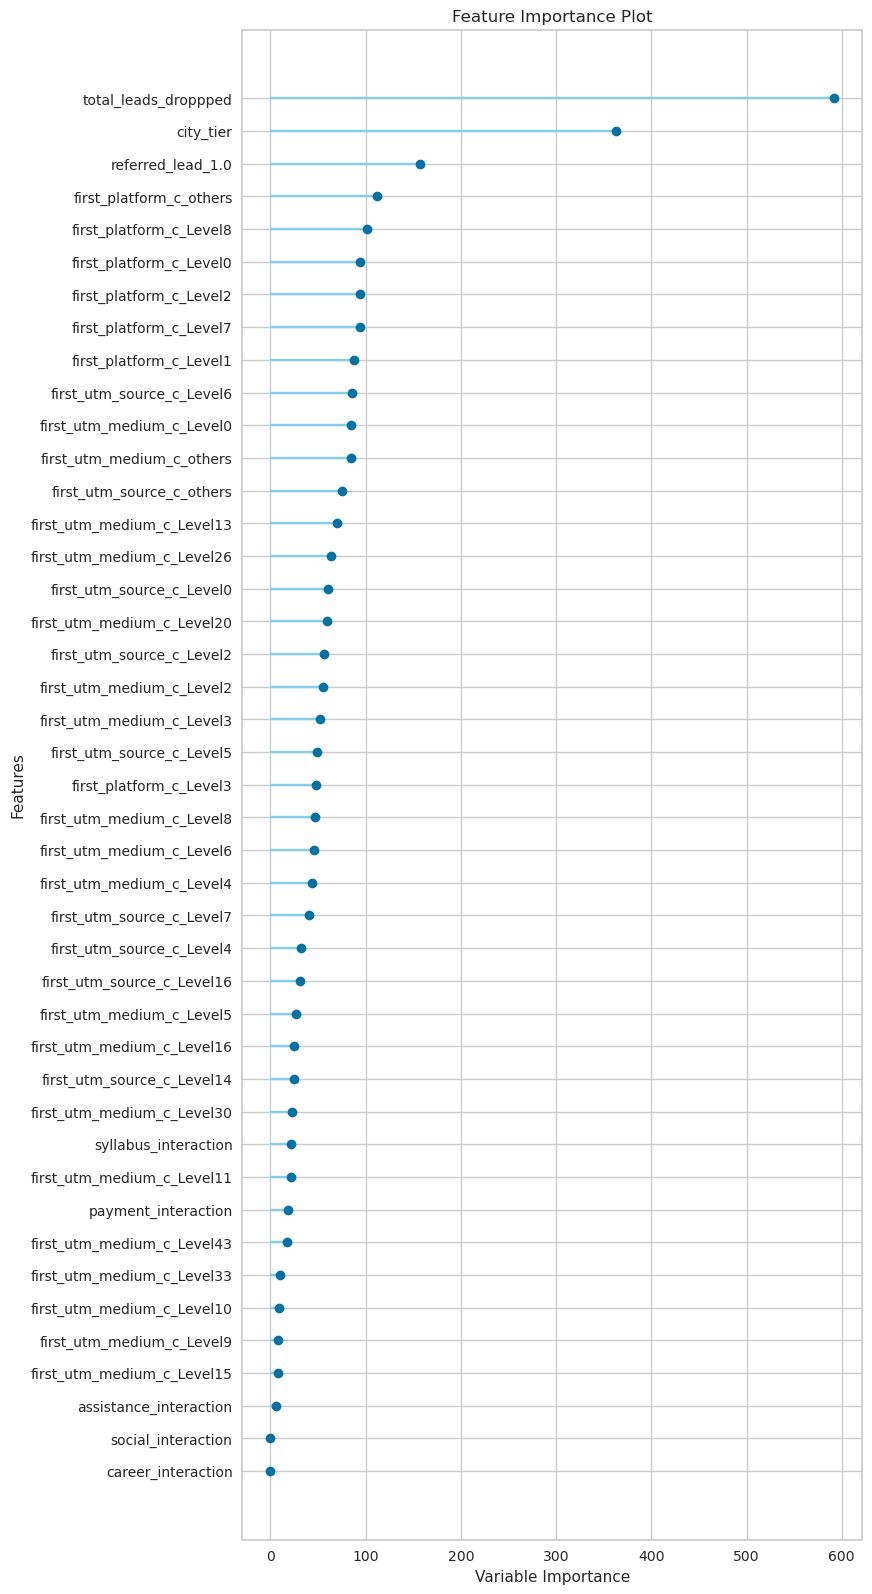

In [14]:
# create feature importance plot
plot_model(lgbm, plot='feature_all')

In [15]:
%matplotlib inline

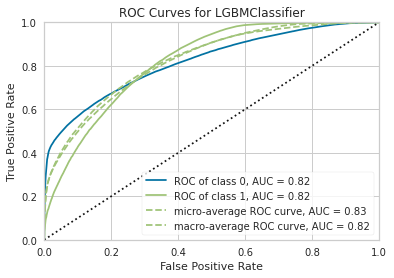

In [16]:
#plot Roc Curve
plot_model(lgbm, plot = 'auc')

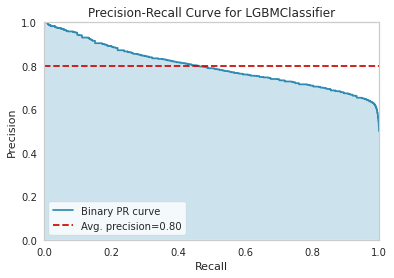

In [17]:
 #plot Precision-recall Curve
plot_model(lgbm, plot = 'pr')

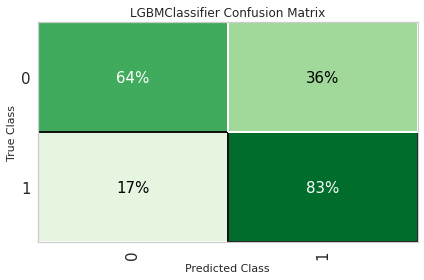

In [18]:
#confusion matrix
plot_model(lgbm, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [19]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

final_dataset = dataset[['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']]
Baseline_model_exp_02 = setup(data = final_dataset, target = 'app_complete_flag', 
                   session_id = 42,fix_imbalance=False,
                   n_jobs=-1,use_gpu=True,
                   log_plots=True, log_data=True,
                   verbose=True,log_profile=False,
                   log_experiment=True,experiment_name='Baseline_model_exp_02',
                   normalize = False ,  transformation = False)

,Description,Value
0,session_id,42
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [20]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 
best_model = compare_models(fold = 5, exclude= ['gbc','knn','qda', 'dummy', 'svm', 'ada'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7385,0.8210,0.8348,0.7018,0.7625,0.4765,0.4855,4.0420
xgboost,Extreme Gradient Boosting,0.7384,0.8209,0.8303,0.7031,0.7614,0.4762,0.4843,0.5760
et,Extra Trees Classifier,0.7366,0.8174,0.8211,0.7042,0.7582,0.4727,0.4795,3.2400
dt,Decision Tree Classifier,0.7363,0.8166,0.8205,0.7041,0.7578,0.4722,0.4788,0.4380
rf,Random Forest Classifier,0.7350,0.8178,0.8432,0.6949,0.7619,0.4693,0.4805,1.3560
lr,Logistic Regression,0.7098,0.7836,0.8224,0.6730,0.7402,0.4189,0.4297,0.2060
ridge,Ridge Classifier,0.7002,0.0000,0.7959,0.6700,0.7275,0.3998,0.4072,0.1780
lda,Linear Discriminant Analysis,0.7002,0.7726,0.7959,0.6700,0.7275,0.3998,0.4072,0.8820
nb,Naive Bayes,0.6701,0.7337,0.8568,0.6255,0.7231,0.3387,0.3650,0.2320


In [21]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret
lgbm  = create_model('lightgbm', fold = 5)

In [83]:
!pip install optuna==0.17.0

     |████████████████████████████████| 107 kB 1.1 MB/s eta 0:00:01
  Created wheel for optuna: filename=optuna-0.17.0-py3-none-any.whl size=144884 sha256=3cee0391da1523c173b45a792ddbc9fd66a3780f56fd44bae1262d84d4f3855c
  Stored in directory: /home/.cache/pip/wheels/d3/98/f0/8352cb2e51b255bc67f75c81a9a8e7e483c3e5b0b685898a7f
Successfully built optuna
  Attempting uninstall: optuna
    Found existing installation: optuna 0.4.0
    Uninstalling optuna-0.4.0:
      Successfully uninstalled optuna-0.4.0


In [81]:
help(tune_model)

Help on function tune_model in module pycaret.classification:

tune_model(estimator, fold: Union[int, Any, NoneType] = None, round: int = 4, n_iter: int = 10, custom_grid: Union[Dict[str, list], Any, NoneType] = None, optimize: str = 'Accuracy', custom_scorer=None, search_library: str = 'scikit-learn', search_algorithm: Union[str, NoneType] = None, early_stopping: Any = False, early_stopping_max_iters: int = 10, choose_better: bool = False, fit_kwargs: Union[dict, NoneType] = None, groups: Union[str, Any, NoneType] = None, return_tuner: bool = False, verbose: bool = True, tuner_verbose: Union[int, bool] = True, return_train_score: bool = False, **kwargs) -> Any
    This function tunes the hyperparameters of a given estimator. The output of
    this function is a score grid with CV scores by fold of the best selected
    model based on ``optimize`` parameter. Metrics evaluated during CV can be
    accessed using the ``get_metrics`` function. Custom metrics can be added
    or removed us

In [84]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC
from optuna.distributions import IntUniformDistribution, LogUniformDistribution  # Updated import
# Define parameter distributions using new Optuna distributions
param_distributions = {
    'num_leaves': IntUniformDistribution(6, 50),  # Use IntUniformDistribution for integer values
    'learning_rate': LogUniformDistribution(0.01, 0.1),  # Use LogUniformDistribution for log-uniform float values
}

# Tune hyperparameters using Optuna with the new distributions
tuned_lgbm = tune_model(
    estimator=lgbm,
    optimize='AUC',  # Adjust metric as needed
    search_library='optuna',
    custom_grid=param_distributions,
    return_tuner=False,  # No need to return tuner object
    fold=10,
    round=10,
    n_iter=50,
    verbose=True
)

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:22:12
Status,. . . . . . . . . . . . . . . . . .,Creating Logs
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Split,Fold,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


ValueError: Deprecated distribution is specified in `actual_estimator__num_leaves` of param_distributions. Rejecting this because it may cause unexpected behavior. Please use new distributions such as FloatDistribution etc.

In [90]:
# Tune hyperparameters using Optuna with the new distributions
tuned_lgbm_optuna,tuner = tune_model(lgbm, 
                                    fold = 10,
                                    optimize = 'AUC',
                                    choose_better=True,
                                    return_tuner=True,
                                    n_iter=100,return_train_score=True)

In [92]:
# Print the final models configuration so that we can use it in the model retraining pipeline 
print(tuner)
print("**"*30)
print(tuned_lgbm_optuna)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('empty_step', 'passthrough'),
                                             ('actual_estimator',
                                              LGBMClassifier(boosting_type='gbdt',
                                                             class_weight=None,
                                                             colsample_bytree=1.0,
                                                             device='gpu',
                                                             importance_type='split',
                                                             learning_rate=0.1,
                                                             max_depth=-1,
                                                             min_child_samples=20,...
                                     